<a href="https://colab.research.google.com/github/babsyco/WirelessSensorNetwork_CLD/blob/main/ELEC5514_final_report_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import math
import random
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from google.colab import files
from IPython.display import Javascript

################### 
# NETWORK DEVICES #
###################

class Server:
  global server_location
  global power_increase
  def __init__(self):
        self.location = server_location
        self.dist_to_server = [0,0]
        self.broadcast_dist = power_increase
        self.receiver_node = ''
        self.nodes_in_range = [] 
        self.request_node_location = ''
        self.message = ''
        self.data = 0
        self.stop_simulation = False
  
  # scan for nodes requesting connection
  def scan_for_requests(self):
    global broadcast_node_location
    # request received
    if self.request_node_location != '':
      # return own location
      for i in nodes:
        if i.location == self.request_node_location:
          i.nodes_in_range.append(self.location)
    # check to see if node is next broadcast node
    if (self.message != ''):
        x,y,data = self.message.split(' ')
        print('\n\nSERVER: package successfully received.\n')
        print(' Data: %s' % str(data))
        print('\n -- ENDING SIMULATION --.\n')
        self.stop_simulation = True
        
class Node:
  global single_sim_distances_unadj
  global single_sim_distances_adj
  global single_sim_route_distances

  def __init__(self, loc):
        self.location = loc
        self.dist_to_server = [0,0]
        self.broadcast_dist = power_increase
        self.receiver_node = ''
        self.nodes_in_range = [] 
        self.request_node_location = ''
        self.message = ''
        self.data = 0
        self.saved_broadcast_dist = 0
  
  # send location to any nodes in range
  def broadcast_request(self):
    print('\nNode %s: sending broadcast request . . .' % str(self.location))
    print('Broadcast distance: %dm' % self.broadcast_dist)
    for i in nodes:
      dist_node_i = get_distance(self.location, i.location)
      if (dist_node_i < self.broadcast_dist):
        i.request_node_location = self.location

        
  # scan for nodes requesting connection
  def scan_for_requests(self):
    # request received
    if self.request_node_location != '':
      # return own location
      for i in nodes:
        if i.location == self.request_node_location:
          i.nodes_in_range.append(self.location)
    global broadcast_node_location
    # check to see if node is next broadcast node
    if (self.message != '') and (self.location != broadcast_node_location):
      x,y,self.data = self.message.split(' ')
      self.data = int(self.data)
      if (x == str(self.location[0])) and (y == str(self.location[1])):
        print('\nNode %s: package successfully received.' % str(self.location))
        broadcast_node_location = self.location
        # not the best place for this but should work
        axs.plot(self.location[0], self.location[1], 'o', color='green', ms=7)
        self.request_node_location = ''
      


  def choose_recv_node(self):
    dist_A_to_server = get_distance(server_location, self.location)
    for i in self.nodes_in_range:
      dist_B_to_server = get_distance(server_location, i)
      if dist_B_to_server < dist_A_to_server:
        dist_A_to_server = dist_B_to_server
        self.receiver_node = i
    if self.receiver_node != '':
      global power_saved
      print('RECEIVER NODE SELECTED!:')
      print(' Location: %s' % str(self.receiver_node))
      print(' Distance to server: %.2fm away.' % get_distance(self.receiver_node, server_location))
      print(' Distance away: %.2fm.' % get_distance(self.location, self.receiver_node))
      # log unadjusted broadcast distance
      single_sim_distances_unadj.append(self.broadcast_dist)
      # set new adjusted broadcast dist
      self.broadcast_dist = get_distance(self.location, self.receiver_node)*1.1
      # log adjusted broadcast distance
      single_sim_distances_adj.append(self.broadcast_dist)
      print(' New broadcast distance: %dm' % self.broadcast_dist)
      # log actual distance to node
      single_sim_route_distances.append(get_distance(self.location, self.receiver_node))

      
  def send_data(self):
    packet = str(self.receiver_node[0]) + ' ' + str(self.receiver_node[1]) + ' ' + str(self.data)
    for i in self.nodes_in_range:
      temp_node = find_node(i)
      temp_node.message = packet
    print('\nNode %s: data has been broadcast.' % str(self.location))
    # clear buffers
    self.request_node_location = ''
    self.message = ''
    self.data = 0
    self.nodes_in_range = []
    global axs
    axs.plot([self.location[0], self.receiver_node[0]], [self.location[1], self.receiver_node[1]], color='green', linewidth=1)   
    

  def check_data_recv(self):
    if message != '':
      x,y,self.data = self.message.split(' ')
      if (x == self.location[0]) and (y == self.location[1]):
        broadcast_node_location = self.location

  def increase_distance(self):
    global power_increase
    self.broadcast_dist = self.broadcast_dist + power_increase


In [15]:
#############
# FUNCTIONS #
#############

# distance between two points
def get_distance(point_a, point_b):
  return math.sqrt((point_a[0] - point_b[0])**2 + (point_a[1] - point_b[1])**2)

# create randomly dispersed nodes
def create_nodes():
  global num_nodes
  global server_location
  for i in range(num_nodes):
    location = [int(random.random() * area), int(random.random() * area)]
    nodes.append(Node(location))  
    nodes[i].dist_to_server = get_distance(location, server_location)

#plot all nodes
def plot_nodes(my_plot):
  x_values = list(range(area))
  y_values = [None]*area
  # get y values
  for i in range(len(nodes)):
    x_val = nodes[i].location[0]
    y_values[x_val] = nodes[i].location[1]
    my_plot.plot(x_values, y_values, 'o', color='black',ms=7)
    my_plot.plot(0, area/2, marker='s', color='orange', ms=15)

# create source node
def assign_source_node(my_plot):
  global broadcast_node_location
  source_node = nodes[int(random.random()*num_nodes)]
  while(source_node.location[0] < area/2):
    source_node = nodes[int(random.random()*num_nodes)]
  source_node.data = 12345
  source_message = str(source_node.data) # no receiver node located yet to prepend data with
  my_plot.plot(source_node.location[0], source_node.location[1], 'o', color='limegreen', ms=10)
  broadcast_node_location = source_node.location

def find_node(location):
  for i in nodes:
    if i.location[0] == location[0]:
      return i

def run_idle_nodes():
  for i in nodes:
      # waiting nodes
      if i.location != broadcast_node_location:
        i.scan_for_requests()
  print('\n(Idle nodes run.)\n')

<IPython.core.display.Javascript object>


 >> New Broadcast Node: [20024, 16042] <<
  Distance to server: 20411.43m

Node [20024, 16042]: sending broadcast request . . .
Broadcast distance: 6000m

(Idle nodes run.)

RECEIVER NODE SELECTED!:
 Location: [18070, 19320]
 Distance to server: 18082.79m away.
 Distance away: 3816.20m.
 New broadcast distance: 4197m

Node [20024, 16042]: data has been broadcast.

Node [18070, 19320]: package successfully received.

(Idle nodes run.)


 >> New Broadcast Node: [18070, 19320] <<
  Distance to server: 18082.79m

Node [18070, 19320]: sending broadcast request . . .
Broadcast distance: 6000m

(Idle nodes run.)


Node [18070, 19320]: sending broadcast request . . .
Broadcast distance: 9000m

(Idle nodes run.)

RECEIVER NODE SELECTED!:
 Location: [10467, 19547]
 Distance to server: 10476.80m away.
 Distance away: 7606.39m.
 New broadcast distance: 8367m

Node [18070, 19320]: data has been broadcast.

Node [10467, 19547]: package successfully received.

(Idle nodes run.)


 >> New Broadcast N

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

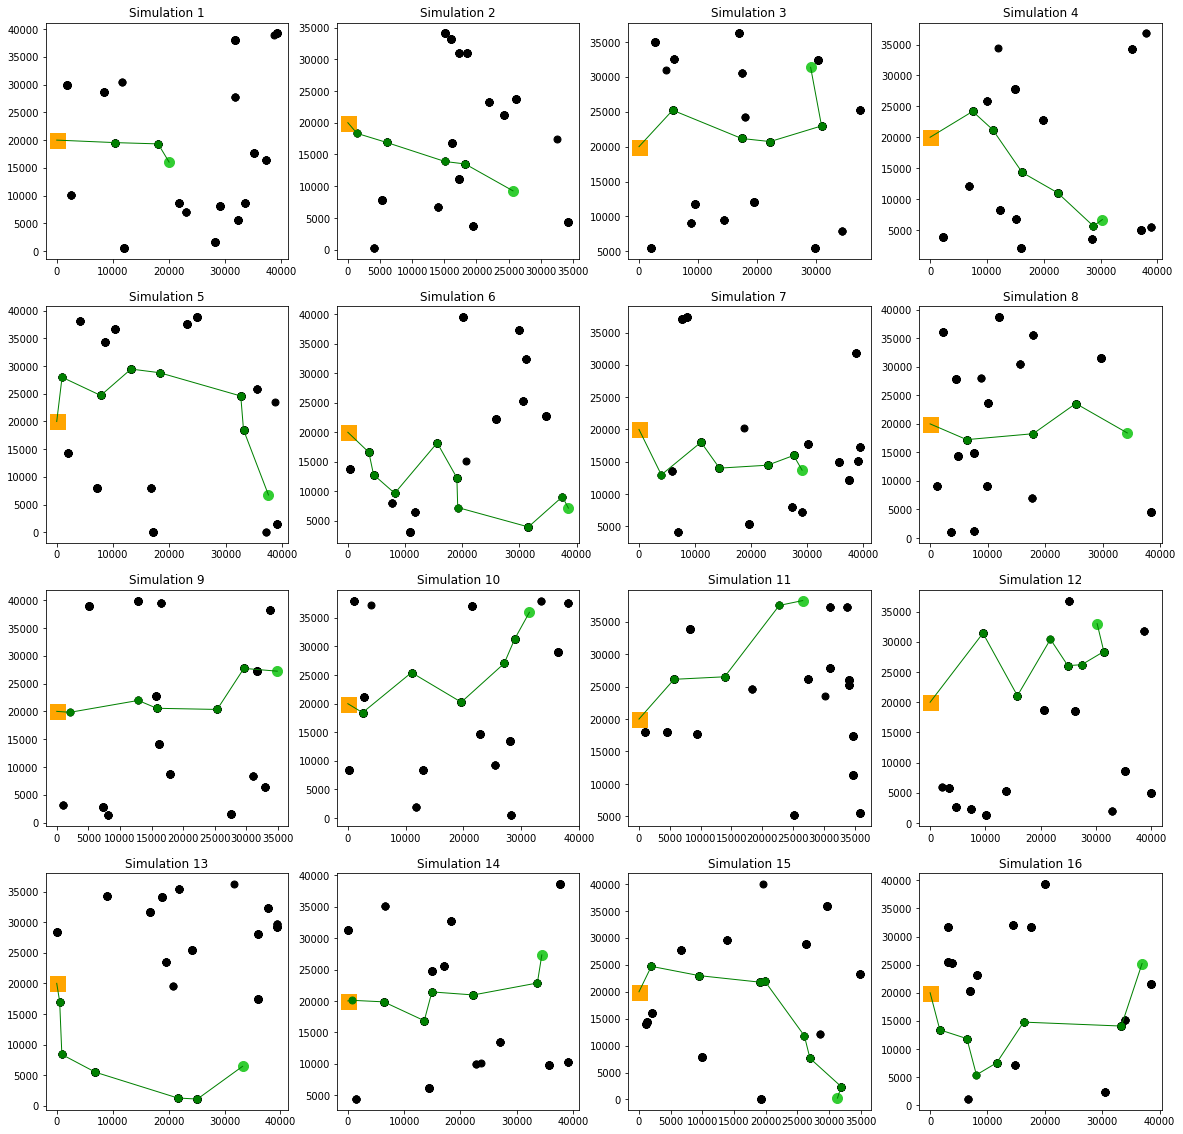

In [16]:
##############
# Simulation #
##############

# USER DEFINABLE PARAMETERS
num_nodes = 20
area = 40000 # side length of a square area, in metres
server_location = [0, area/2] # set to be halfway up the left edge
power_increase = 3000 # amount each node increases its broadcast power for another broadcast, if it fails to find an available node.

# CONFIGURE CELL OUTPUT
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'''))


#SIMULATION VARIABLES AND OBJECTS
nodes = []
broadcast_node_location = ''
fig, axl = plt.subplots(4, 4, figsize = (20, 20))
server = ''
broadcast_node = ''
source_node = ''

# LOGGING DATA
# for a single simulation
single_sim_distances_unadj = []
single_sim_route_distances = []
single_sim_distances_adj = []
# for all simulations (list of lists)
all_sim_distances_unadj = []
all_sim_route_distances = []
all_sim_distances_adj = []
# summary data for each simulation
sim_totals_broadcast_unadj = []
sim_totals_broadcast_adj = []
sim_totals_routes = []


# INITIALISATION #
def initialise_simulation():
  global server
  global broadcast_node
  global source_node
  global nodes
  global broadcast_node_location
  global power_saved
  global y_values

  broadcast_node_location = ''
  #server = ''
  #broadcast_node = ''
  nodes = []
  #source_node = ''

  create_nodes()
  # create plot
  #fig, axs = plt.subplots(1, 1)
  plot_nodes(axs)
  # create server
  server = Server()
  nodes.append(server)
  # Create source node
  source_node = assign_source_node(axs)
  # Assign as first broadcast node
  broadcast_node = find_node(broadcast_node_location)

# Run a Simulation round
def run_simulation():
  global server
  global broadcast_node
  global source_node
  global nodes

  while not server.stop_simulation:
    print("\n >> New Broadcast Node: %s <<" % str(broadcast_node.location))
    print('  Distance to server: %.2fm' % get_distance(broadcast_node.location, server_location))
        
    # Broadcast node runs this loop until it finds a receive node
    # Idle nodes continue to scan for transmission requests
    while broadcast_node.receiver_node == '':
      # update broadcast node
      broadcast_node = find_node(broadcast_node_location)
      # increase broadcast distance
      broadcast_node.increase_distance()
      # send broadcast request
      broadcast_node.broadcast_request()
      run_idle_nodes()
      # choose recv node is one is possible
      broadcast_node.choose_recv_node()
    # next node located, data sent, send buffer wiped
    # broadcast node location of simulator updated
    broadcast_node.send_data()
    run_idle_nodes()
    broadcast_node = find_node(broadcast_node_location)

######################################
# BEGIN: RUN 16 ROUNDS OF SIMULATION #
######################################
for i in range(4):
  for j in range(4):
    axs = axl[i,j]
    initialise_simulation()
    run_simulation()
    # store data for simulation round
    all_sim_distances_unadj.append(single_sim_distances_unadj)
    all_sim_distances_adj.append(single_sim_distances_adj)
    all_sim_route_distances.append(single_sim_route_distances)

    # clear data buffers
    single_sim_distances_adj = []
    single_sim_distances_unadj = []
    single_sim_route_distances = []

    axs.title.set_text('Simulation %d' % (1+j+(i*4)))


# CREATE SUMMARY DATA OF EACH SIMULATION
print("TOTALS:")
# calculate summaries
for i in range(len(all_sim_distances_unadj)):
  sim_totals_broadcast_unadj.append(sum(all_sim_distances_unadj[i]))
  sim_totals_broadcast_adj.append(sum(all_sim_distances_adj[i]))
  sim_totals_routes.append(sum(all_sim_route_distances[i]))

  print("Simulation %d:" % (i+1))
  print('Unadjusted broadcast length: %.2f' % sim_totals_broadcast_unadj[i])
  print('Adjusted broadcast length: %.2f' % sim_totals_broadcast_adj[i])
  print('Actual route length: %.2f' % sim_totals_routes[i])
print(' ')


# SAVE RESULTS
if True: 
  filename = 'ELEC5514_simulation_output.png'
  plt.savefig(filename)
  files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

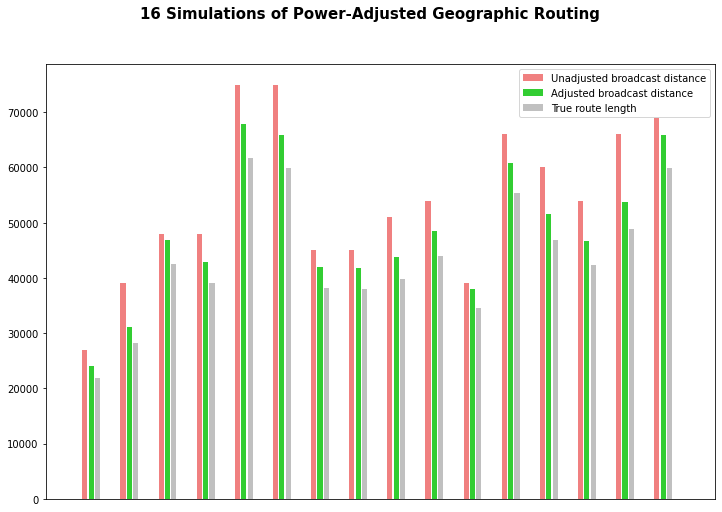

In [18]:
############# 
# PLOT DATA #
#############

x_vals = list(range(16*6))
y_vals_unadj = [0]*16*6
y_vals_adj = [0]*16*6
y_vals_routes = [0]*16*6


for i in range(16):
  j = i*6 + 1 
  k = i*6 + 2
  l = i*6 + 3
  
  y_vals_unadj[j] = sim_totals_broadcast_unadj[i]
  y_vals_adj[k] = sim_totals_broadcast_adj[i]
  y_vals_routes[l] = sim_totals_routes[i]


fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x_vals, y_vals_unadj, color='lightcoral')
ax.bar(x_vals, y_vals_adj, color='limegreen')
ax.bar(x_vals, y_vals_routes, color='silver')
ax.set_xticks([])
ax.legend(['Unadjusted broadcast distance', 'Adjusted broadcast distance', 'True route length'])
ax.legend(['Unadjusted broadcast distance', 'Adjusted broadcast distance', 'True route length'])
fig.suptitle('16 Simulations of Power-Adjusted Geographic Routing', fontsize=15, fontweight='bold')

# save results
if True: 
  filename = 'ELEC5514_summary_data.png'
  plt.savefig(filename)
  files.download(filename)
  
# PRINT FULL RAW DATA
if False:
  for i in range(len(all_sim_distances_unadj)):
    print(all_sim_distances_unadj[i])
    print(all_sim_distances_adj[i])
    print(all_sim_route_distances[i])
